### Finding the main method of a java file and adding @Benchmark annotation

This program will iterate over every file in the directory and add @Benchmark tag over each function.

In [4]:
import os
import re

# Define the folder containing Java files
folder_path = r'C:\Users\Mettle\Desktop\Java-master\java-combinations\src\main\java\com\hmkcode'

# Create the 'benchmark_files' folder if it doesn't exist
if not os.path.exists('benchmark_files'):
    os.makedirs('benchmark_files')

# Function to process each Java file
def process_java_file(java_file_path):
    benchmark_file_path = os.path.join('benchmark_files', os.path.basename(java_file_path))
    add_benchmark_annotation(java_file_path, benchmark_file_path)
    add_counters(benchmark_file_path)
    method_invocation_annotation(benchmark_file_path)
   
# Iterate over each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.java'):
        file_path = os.path.join(folder_path, file_name)
        process_java_file(file_path)
        print(f"Completed annotation for file : {file_name} ")


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Mettle\\Desktop\\Java-master\\java-combinations\\src\\main\\java\\com\\hmkcode'

#### Loop counter

*Currently not handling case with loops without braces.*

In [16]:
def add_counters(file_path):
    with open(file_path, 'r') as file:
            java_code = file.read()
    # Regex pattern for finding for loops and while loops
    pattern = r'(?P<loop>(for\s*\([^\)]*\)\s*\{)|(while\s*\([^\)]*\)\s*\{))'
    
    def add_counter(match):
        loop = match.group('loop')
        return loop + '\n    counter++;'
    
    # Replace each loop with the loop plus counter++
    modified_java_code = re.sub(pattern, add_counter, java_code)
    with open(file_path, 'w') as file:
        file.write(modified_java_code)

#### @Benchmark Annotation

In [17]:
def add_benchmark_annotation(file_path, benchmark_file_path):
    pattern = r'(?<!\/\/)(?<!\/\*)\b(?:public\s+|private\s+|protected\s+|static\s+|final\s+|native\s+|synchronized\s+|abstract\s+|transient\s+)*[\$_\w<>\[\]]*\s+\w+\s*\([^\)]*\)?\s*\{'

    with open(file_path, 'r') as file:
        java_code = file.read()

    # Find all occurrences of method declarations in the Java code
    matches = re.finditer(pattern, java_code)

    modified_java_code = ''
    previous_end_index = 0

    # Loop through each method occurrence
    for match in matches:
        start_index = match.start()
        end_index = match.end()
        
        method_declaration = java_code[start_index:end_index]
        
        # Insert @Benchmark annotation just above the method declaration
        modified_java_code += java_code[previous_end_index:start_index] + '@Benchmark\n' + method_declaration

        previous_end_index = end_index

    modified_java_code += java_code[previous_end_index:]
    with open(benchmark_file_path, 'w') as file:
        file.write(modified_java_code)

#### Count method invocation values

In [51]:
def method_invocation_annotation(file_path):
    method_pattern = r'(?P<method>(?<!\/\/)(?<!\/\*)\b(?:public\s+|private\s+|protected\s+|static\s+|final\s+|native\s+|synchronized\s+|abstract\s+|transient\s+)*[\$_\w<>\[\]]*\s+\w+\s*\([^\)]*\)\s*\{[^\}]*?\})'
    with open(file_path, 'r') as file:
        java_code = file.read()
    def add_counter(match):
        method = match.group()
        modified_method = method.replace('{', '{\n    method_counter++;\n')
        return modified_method

    # Replace each method with additional code added inside
    modified_java_code = re.sub(method_pattern, add_counter, java_code)
    with open(file_path, 'w') as file:
        file.write(modified_java_code)

# Getting Codeforces submissions

### Generate URL

In [8]:
import requests
import hashlib
import time
import random
from bs4 import BeautifulSoup
def get_url(from_val):
    key = "baa5c566fa5bdeb92494876e5bcac06b6798d8fe"
    secret = "0d686bfc8a3c654a569b93e3d1d12803d25264f1"
    count = 1000
    current_time = int(time.time())
    random_number = random.randint(100000, 999999)
    method_fetched = "contest.status"
    string_to_hash = f"{random_number}/{method_fetched}?apiKey={key}&contestId=1928&count={count}&from={from_val}&time={current_time}#{secret}"
    sha512_hash = hashlib.sha512(string_to_hash.encode()).hexdigest()
    req_url = f"https://codeforces.com/api/{method_fetched}?apiKey={key}&contestId=1928&count={count}&from={from_val}&time={current_time}&apiSig={random_number}{sha512_hash}"
    return req_url

### Next step is to make a crawler to incrementally fetch data from Codeforces

In [9]:
import csv
import os.path
from os import path

# Function to check if file exists and create it if it doesn't
def create_csv_file(file_path):
    if not path.exists(file_path):
        with open(file_path, 'w', newline='') as file:
            # Create a CSV writer object
            csv_writer = csv.writer(file)
            # Write header row
            csv_writer.writerow(['id', 'contest_id', 'author','creation_time_seconds', 'relative_time_seconds', 'problem_name', 'problem_type', 'programming_language', 'verdict', 'test_set', 'passed_test_count', 'time_consumed_millis', 'memory_consumed_bytes'])

In [10]:
def append_to_csv(data, file_path):
    fieldnames = ['id', 'contest_id', 'author','creation_time_seconds', 'relative_time_seconds', 'problem_name', 'problem_type', 'programming_language', 'verdict', 'test_set', 'passed_test_count', 'time_consumed_millis', 'memory_consumed_bytes']
    
    file_exists = os.path.isfile(file_path)
    
    with open(file_path, 'a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()  # Write header only if file is new
        writer.writerow(data)

def make_request_and_append_to_csv(from_val, file_path):
    req_url = get_url(from_val)
    response = requests.get(req_url)
    if response.status_code == 200:
        data = response.json()
        for item in data['result']:
            csv_data = {
                'id': item['id'],
                'contest_id': item['contestId'],
                'author': item['author']['members'][0]['handle'],
                'creation_time_seconds': item['creationTimeSeconds'],
                'relative_time_seconds': item['relativeTimeSeconds'],
                'problem_name': item['problem']['name'],
                'problem_type': item['problem']['type'],
                'programming_language': item['programmingLanguage'],
                'verdict': item['verdict'],
                'test_set': item['testset'],
                'passed_test_count': item['passedTestCount'],
                'time_consumed_millis': item['timeConsumedMillis'],
                'memory_consumed_bytes': item['memoryConsumedBytes']
            }
            append_to_csv(csv_data, file_path)
    else:
        print("Request failed with status code:", response.status_code)

In [12]:
# Number of iterations
num_requests = 200
# Initial value to start 1.
from_val = 1

csv_file = 'output.csv'

create_csv_file(csv_file)

for i in range(num_requests):
    make_request_and_append_to_csv(from_val, 'output.csv')
    from_val += 1000  
    time.sleep(5)
    print(f"Completed: {i} / {num_requests} , Index value : {from_val}")

Completed: 0 / 200 , Index value : 1001
Completed: 1 / 200 , Index value : 2001
Completed: 2 / 200 , Index value : 3001
Completed: 3 / 200 , Index value : 4001
Completed: 4 / 200 , Index value : 5001
Completed: 5 / 200 , Index value : 6001
Completed: 6 / 200 , Index value : 7001
Completed: 7 / 200 , Index value : 8001
Completed: 8 / 200 , Index value : 9001
Completed: 9 / 200 , Index value : 10001
Completed: 10 / 200 , Index value : 11001
Completed: 11 / 200 , Index value : 12001
Completed: 12 / 200 , Index value : 13001
Completed: 13 / 200 , Index value : 14001
Completed: 14 / 200 , Index value : 15001
Completed: 15 / 200 , Index value : 16001
Completed: 16 / 200 , Index value : 17001
Completed: 17 / 200 , Index value : 18001
Completed: 18 / 200 , Index value : 19001
Completed: 19 / 200 , Index value : 20001
Completed: 20 / 200 , Index value : 21001
Completed: 21 / 200 , Index value : 22001
Completed: 22 / 200 , Index value : 23001
Completed: 23 / 200 , Index value : 24001
Completed: 

### We can now filter and find submissions of interest

**We've fetched all problems from contestid : 1928**

Each contest contains several problems. For this contest, there are the following problems : 

- **A : Rectangle Cutting** (20,553 users attempted)
- **B : Equalize** (14,643 users attempted)
- **C : Physical education lesson** (7066 users attempted)
- **D : Lonely Mountain Dungeons** (3588 users attempted)
- **E : Modular Sequence** (1418 users attempted)
- **F : Digital Patterns** (193 users attempted)
  
Now I filter by the problem and look for individuals that made multiple submissions for a given problem. In order to be considered, they must have a correct submissions (no compilation errors or wrong answer) and be written in C++ language.

In [85]:
import pandas as pd

# Adjust CSV reading parameters
df = pd.read_csv('output.csv')
# Remove entries with testset value 'WRONG_ANSWER'
df = df[df['verdict'] != 'WRONG_ANSWER']
df = df[df['verdict'] != 'COMPILATION_ERROR']
df = df[df['verdict'] != 'RUNTIME_ERROR'] 
df = df[df['programming_language'].str.contains('Java')]
df = df[df['problem_name'] == 'Equalize']

#Remove authors that only submitted once.
author_counts = df['author'].value_counts()
multiple_submissions_authors = author_counts[author_counts > 1].index

# Filter the DataFrame to only keep elements where the author appears more than once
filtered_df = df[df['author'].isin(multiple_submissions_authors)]

filtered_df.to_csv('filtered_output.csv', index=False)

#Retrieve submissions ids
id_values = filtered_df['id'].tolist()

print(len(id_values))

179


### Now we fetch the code for all these submissions

To fetch the submissions, we create a webscraper. The website's DDoS protection eventually kicks in so we implement several strategies : 
- Randomized access times [11, 20] seconds
- Randomized user agent property to make it seem like multiple users are accessing from same IP.
- Selenium web driver rather than requests. This is necessary to load Javascript and prevent detection, as requests does not load Javascript and therefore makes it easy to detect. 
- Rotating proxy addresses

In [86]:
!pip install selenium
!pip install random_user_agent
!pip install lxml
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import os
import time
import random
from random_user_agent.user_agent import UserAgent
from random_user_agent.params import SoftwareName, OperatingSystem
from selenium.webdriver.common.proxy import Proxy

DEPRECATION: Loading egg at /Users/benjaminboucher/anaconda3/lib/python3.11/site-packages/enum34-1.1.10-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/benjaminboucher/anaconda3/lib/python3.11/site-packages/codeforces_api-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/benjaminboucher/anaconda3/lib/python3.11/site-packages/enum34-1.1.10-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at http

This fetches a list of usable proxy addresses, updated every ten minutes. We can execute this function every ten minutes and fetch all the new addresses.

In [43]:
def fetch_proxy_urls(driver):
    driver.get('https://www.sslproxies.org/')
    
    # Extract the HTML content of the page
    page_source = driver.page_source

    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(page_source, 'html.parser')

    # Find the table containing proxy information
    proxy_table = soup.find('table', class_='table')

    # Extract IP addresses and ports from the table rows
    proxy_server_urls = []
    if proxy_table:
        rows = proxy_table.find_all('tr')
        for row in rows[1:]:  # Skip the header row
            columns = row.find_all('td')
            ip_address = columns[0].text
            port = columns[1].text
            proxy_url = f"{ip_address}:{port}"
            proxy_server_urls.append(proxy_url)
    driver.quit()
    return proxy_server_urls


In [87]:
# Define the directory to store code files
directory = "data_collection"
if not os.path.exists(directory):
    os.makedirs(directory)

# Initialize UserAgent object
software_names = [SoftwareName.EDGE.value, SoftwareName.CHROME.value, SoftwareName.CHROMIUM.value, SoftwareName.ANDROID.value, SoftwareName.FIREFOX.value, SoftwareName.OPERA.value, SoftwareName.SAFARI.value]
operating_systems = [OperatingSystem.WINDOWS.value, OperatingSystem.LINUX.value, OperatingSystem.MAC.value]
user_agent_rotator = UserAgent(software_names=software_names, operating_systems=operating_systems, limit=100)

#chrome_options = Options()
#chrome_options.add_argument(f'user-agent={user_agent}')
#driver = webdriver.Chrome(options=chrome_options)
#proxy_server_urls = fetch_proxy_urls(driver)
# Iterate over each submission ID
for submission_id in id_values:
    try:
        # Randomizing sleep duration (Must be greater than 10 to prevent DDOS protection from kicking in)
        #if count % 35 == 0:
        #    proxy_server_urls = fetch_proxy_urls(driver)
        file_path = os.path.join(directory, f"submission_{submission_id}.txt")
        if os.path.isfile(file_path):           
            continue
        # URL of the submission page
        submission_url = f"https://codeforces.com/contest/1928/submission/{submission_id}"

        # Set a random User-Agent for each request
        user_agent = user_agent_rotator.get_random_user_agent()
          
        # Set up Chrome options
        chrome_options = Options()

        # Set proxy server URL
        #PROXY = proxy_server_urls[random.randint(0, len(proxy_server_urls) - 1)]
        #print(PROXY)
        # Add user agent, incognito mode, and headless mode to Chrome options
        chrome_options.add_argument(f'user-agent={user_agent}')
        chrome_options.add_argument("--incognito")
        chrome_options.add_argument("--headless")

        # Set proxy server for Chrome WebDriver
        #chrome_options.add_argument("--proxy-server=%s" % PROXY)

        # Initialize Chrome WebDriver with options
        driver = webdriver.Chrome(options=chrome_options)

        # Navigate to the submission page
        driver.get(submission_url)
        time.sleep(random.randint(9, 12))
        # Extract the HTML content of the page
        page_source = driver.page_source
        
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(page_source, 'lxml')

        not_allowed_messages = soup.find_all(string='403 Forbidden')

        if not_allowed_messages:
            print(f"Scraping detected.")
            time.sleep(random.randint(400, 500))
            continue
        
        # Extract the code from the page
        code_element = soup.find('pre', class_='prettyprint')
        
        if code_element:
            code = code_element.get_text()

            # Write the code to a .txt file
            file_path = os.path.join(directory, f"submission_{submission_id}.txt")
            with open(file_path, "w", encoding="utf-8") as file:
                file.write(code)
            print(f"Code found for submission {submission_id}.")
        else:
            print(f"No code found for submission {submission_id}.")    
        time.sleep(5)
        driver.quit()
    except Exception as e:
        print(f"An error occurred for submission {submission_id}: {e}")

Code found for submission 253988583.
Code found for submission 253988041.
Code found for submission 253987870.
Code found for submission 253987678.
Code found for submission 251555388.
Code found for submission 251552234.
Code found for submission 250360802.
Code found for submission 250354872.
Code found for submission 250322420.
Code found for submission 250321938.
Code found for submission 250321765.
Code found for submission 250168121.
Code found for submission 249949785.
Scraping detected.
Code found for submission 249837163.
Code found for submission 249833884.
Code found for submission 248474308.
Code found for submission 248469764.
Code found for submission 247788407.
Code found for submission 247758677.
Code found for submission 247717033.
Code found for submission 247705848.
Code found for submission 247653712.
Code found for submission 247636847.
Scraping detected.
No code found for submission 247629796.
Scraping detected.
Scraping detected.
Scraping detected.
Scraping detec

KeyboardInterrupt: 

## Creating Bag of Words model

#### Pre-processing the data

In [3]:
!pip install nltk
!pip install sctokenizer

DEPRECATION: Loading egg at /Users/benjaminboucher/anaconda3/lib/python3.11/site-packages/enum34-1.1.10-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/benjaminboucher/anaconda3/lib/python3.11/site-packages/codeforces_api-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3 -> 24.0
[notice] To update, run: pip install --upgrade pip
DEPRECATION: Loading egg at /Users/benjaminboucher/anaconda3/lib/python3.11/site-packages/enum34-1.1.10-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at http

In [71]:
import os
import pandas as pd
from sctokenizer import CppTokenizer
from sklearn.metrics import mean_squared_error

def preprocess_code(code):
    code = code.replace(';', ';\n')
    return code

def tokenize_cpp_file(file_path):
    tokenizer = CppTokenizer()
    with open(file_path) as file:
        source = file.read()
        code = preprocess_code(source)
        tokens = [token.token_value for token in tokenizer.tokenize(code) if token.token_value not in {'#', ';'}]

        
        return ','.join(token.token_value for token in tokens)

def process_code_files(directory, output_csv):
    df_list = []

    for file_name in os.listdir(directory):
        if file_name.endswith(".txt"):
            submission_id = file_name.split('_')[-1].split('.')[0]

            file_path = os.path.join(directory, file_name)
            tokens = tokenize_cpp_file(file_path)
            
            df_list.append({'id': submission_id,
                            'tokens': tokens})

    df = pd.DataFrame(df_list)

    output_df = pd.read_csv(output_csv)
    output_df = output_df[['id', 'time_consumed_millis', 'memory_consumed_bytes']]

  
    df['id'] = df['id'].astype(str)
    output_df['id'] = output_df['id'].astype(str)


    final_df = pd.merge(df, output_df, on='id', how='left')
    filtered_train_df = final_df[(final_df['time_consumed_millis'] != 0) & (final_df['time_consumed_millis'] != 1000)]

    # Save final_df to CSV
    filtered_train_df.to_csv('model_data.csv', index=False)

directory = "code_files"
output_csv = "output.csv"
process_code_files(directory, output_csv)

KeyError: 'id'

## Constructing the model

We're going to make 2 models : 
1. Execution time
2. Memory consumption

#### Splitting the data

In [72]:
from sklearn.model_selection import train_test_split
import numpy as np


df = pd.read_csv('model_data.csv')
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

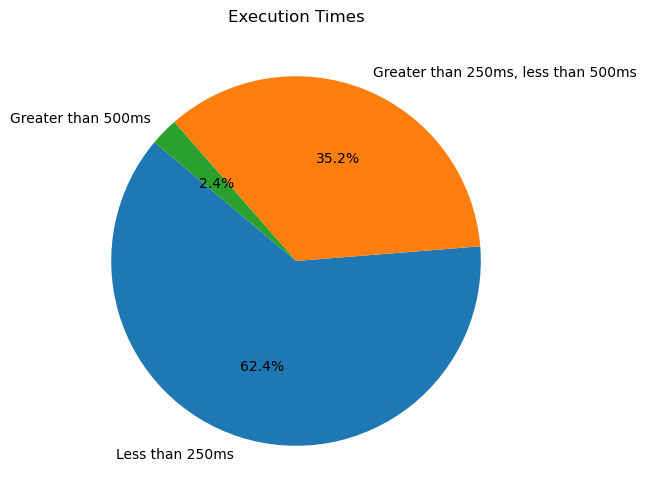

In [73]:
import matplotlib.pyplot as plt
def categorize_time(time):
    if time < 10:
        return 'Error'
    elif time < 250:
        return 'Less than 250ms'
    elif time < 500:
        return 'Greater than 250ms, less than 500ms'
    else:
        return 'Greater than 500ms'


df['time_category'] = df['time_consumed_millis'].apply(categorize_time)

time_category_counts = df['time_category'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(time_category_counts, labels=time_category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Execution Times')
plt.show()

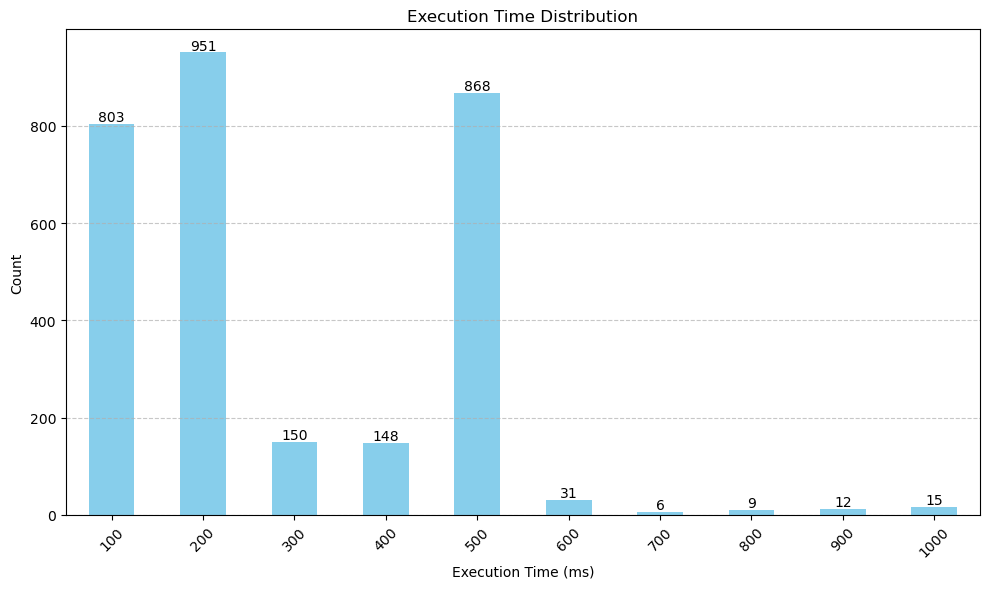

In [74]:
def categorize_time(time):
    return int(time / 100) * 100 + 100  

df['time_category'] = df['time_consumed_millis'].apply(categorize_time)

time_category_counts = df['time_category'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = time_category_counts.plot(kind='bar', color='skyblue')
plt.title('Execution Time Distribution')
plt.xlabel('Execution Time (ms)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Apply TF-IDF

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = []

for index, row in train_df.iterrows():
    tokens = row['tokens']
    corpus.append(' '.join(tokens.split()))

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(corpus)

Applying TF-IDF to test set

In [76]:
test_corpus = []

for index, row in test_df.iterrows():
    tokens = row['tokens']
    test_corpus.append(' '.join(tokens.split()))

test_tfidf_matrix = vectorizer.transform(test_corpus)

In [77]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000) 
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
test_tfidf_matrix_reduced = svd.transform(test_tfidf_matrix)

### Baseline Model - Time consumed in milliseconds

In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(tfidf_matrix, train_df['time_consumed_millis'])

predicted_values = dummy_regressor.predict(test_tfidf_matrix)

mse = mean_squared_error(test_df['time_consumed_millis'], predicted_values)
print("Root Mean Squared Error (RMSE) of the baseline model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the baseline model: 168.92


In [ ]:
from sklearn.neural_network import MLPRegressor
mlpreg = MLPRegressor(hidden_layer_sizes=(tfidf_matrix_reduced.shape[0],), alpha=0.5, max_iter=1500, random_state=42, solver='adam')
mlpreg.fit(tfidf_matrix_reduced, train_df['time_consumed_millis'])

predicted_values = mlpreg.predict(test_tfidf_matrix_reduced)

mse = mean_squared_error(test_df['time_consumed_millis'], predicted_values)
print("Root Mean Squared Error (RMSE) of the baseline model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the baseline model: 105.65

Interestingly, this regressor benefits from removing features in the data, keeping only the ones with the highest SVD values.

#### Gridsearch on MLPRegressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (300,), (tfidf_matrix.shape[0],)],
    'alpha': [ 0.01, 0.1, 0.5], 
    'max_iter': [1500], 
    'solver': ['adam'], 
    'activation': ['logistic'] 
}

mlpreg = MLPRegressor(random_state=42)
grid_search = GridSearchCV(mlpreg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(tfidf_matrix, train_df['time_consumed_millis'])

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

best_model = grid_search.best_estimator_
predicted_values = best_model.predict(test_tfidf_matrix)

mse = mean_squared_error(test_df['time_consumed_millis'], predicted_values)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) of the best model:", rmse)

Best hyperparameters: {'activation': 'logistic', 'alpha': 0.5, 'hidden_layer_sizes': (439,), 'max_iter': 1500, 'solver': 'adam'}

Tuned model : Root Mean Squared Error (RMSE) of the best model: 105.65

### **Observations**
Current error is quite high. This is indicative that either our data either has errors or our model has low predictive abilities. I found in the data that we were conserving runtime errors which made it so we had skewed outputs for time in milliseconds.

In [ ]:
from sklearn.linear_model import LogisticRegression
logit_reg = LogisticRegression(random_state=42, penalty="l1", C=0.5, solver='saga')
logit_reg.fit(tfidf_matrix, train_df['time_consumed_millis'])
predicted_values = logit_reg.predict(test_tfidf_matrix)
mse = mean_squared_error(test_df['time_consumed_millis'], predicted_values)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE) of the Logistic Regression model:",rmse)

The logisitic regressor has slightly better predictive abilities than a dummy regressor.

Root Mean Squared Error (RMSE) of the Logistic Regression model: 137.84

#### **XGBoost**

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(tfidf_matrix, label=train_df['time_consumed_millis'])
dtest = xgb.DMatrix(test_tfidf_matrix, label=test_df['time_consumed_millis'])

params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'max_depth': 10
}

num_rounds = 1000
xgb_model = xgb.train(params, dtrain, num_rounds)

y_pred = xgb_model.predict(dtest)

mse = mean_squared_error(test_df['time_consumed_millis'], y_pred)
print("Root Mean Squared Error (RMSE) of the XGBoost model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the XGBoost model: 84.08

#### **Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(tfidf_matrix, train_df['time_consumed_millis'])

predicted_values = linear_reg.predict(test_tfidf_matrix)

mse = mean_squared_error(test_df['time_consumed_millis'], predicted_values)
print("Root Mean Squared Error (RMSE) of the Linear Regression model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the Linear Regression model: 352.3574170729968

This model has really poor predictive abilities.

#### **Random forest Regressor**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(max_depth=7, random_state=42, n_estimators=100)
random_forest_model.fit(tfidf_matrix, train_df['time_consumed_millis'])
predict_vals_rf = random_forest_model.predict(test_tfidf_matrix)

mse = mean_squared_error(test_df['time_consumed_millis'], predict_vals_rf)
print("Root Mean Squared Error (RMSE) of the Random forest model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the Random forest model: 81.74

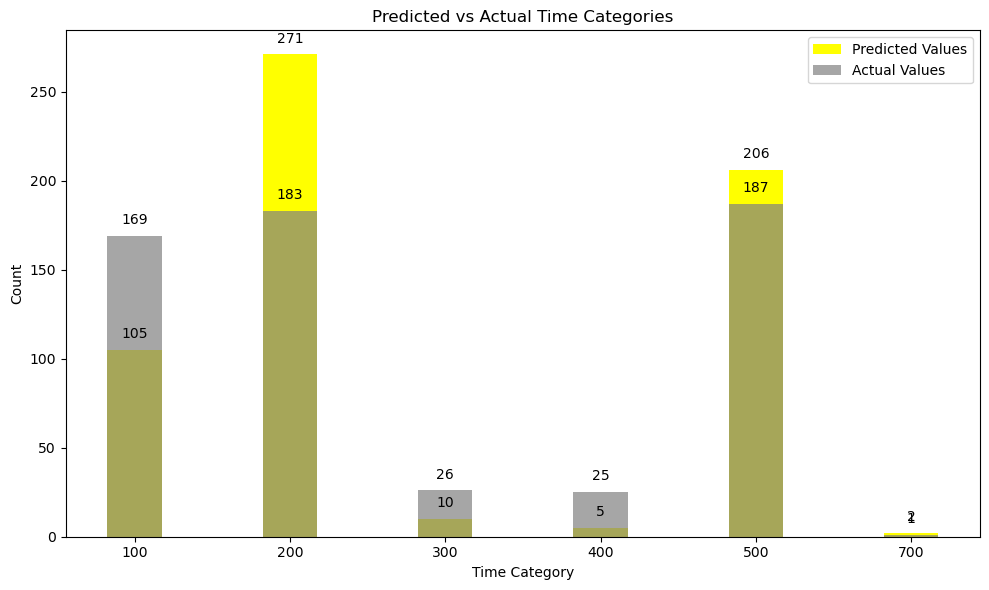

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

def categorize_time(time):
    return int(time / 100) * 100 + 100

df = pd.DataFrame({'predicted_time': predict_vals_rf, 'actual_time': test_df['time_consumed_millis']})
df['time_category'] = df['predicted_time'].apply(categorize_time)
df['time_category_actual'] = df['actual_time'].apply(categorize_time)

common_categories = sorted(set(df['time_category']).intersection(df['time_category_actual']))

combined_counts = pd.DataFrame(index=common_categories)
combined_counts['Predicted'] = df[df['time_category'].isin(common_categories)]['time_category'].value_counts().sort_index()
combined_counts['Actual'] = df[df['time_category_actual'].isin(common_categories)]['time_category_actual'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(common_categories))

plt.bar(index, combined_counts['Predicted'], bar_width, label='Predicted Values', color='yellow')
plt.bar(index, combined_counts['Actual'], bar_width, label='Actual Values', color='gray', alpha=0.7)

plt.xlabel('Time Category')
plt.ylabel('Count')
plt.title('Predicted vs Actual Time Categories')
plt.xticks(index, common_categories)
plt.legend()

# Annotate bar heights
for i, (pred_count, actual_count) in enumerate(zip(combined_counts['Predicted'], combined_counts['Actual'])):
    plt.text(i, pred_count + 5, str(pred_count), ha='center', va='bottom', color='black')
    plt.text(i, actual_count + 5, str(actual_count), ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()


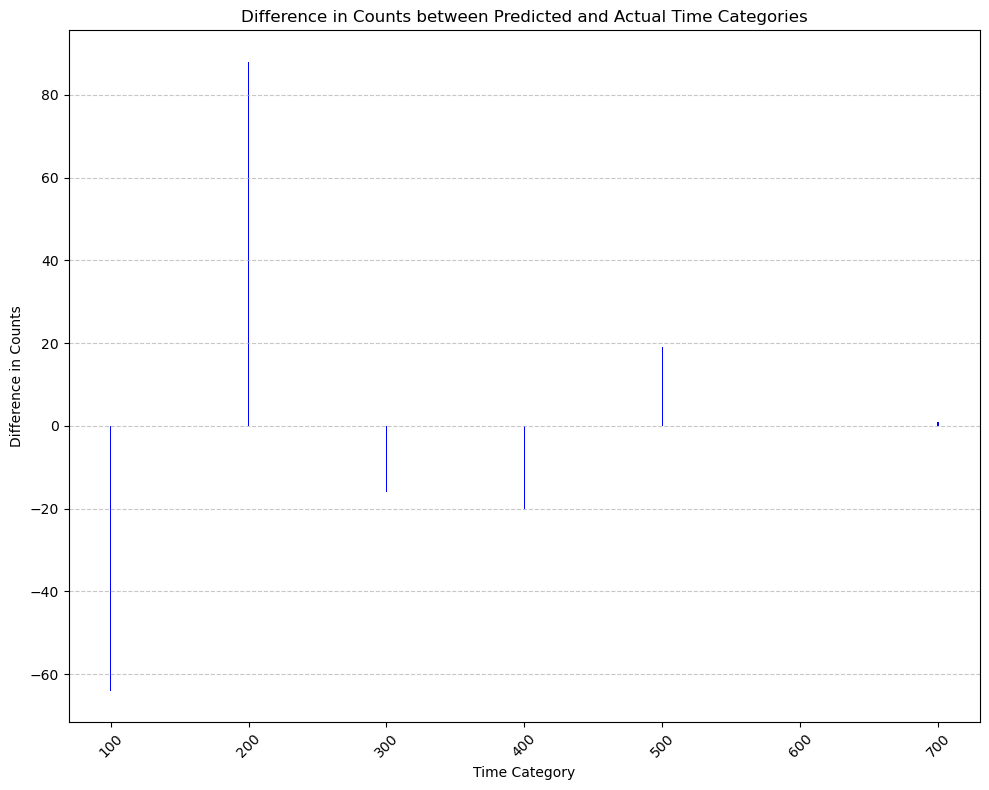

In [130]:
difference_counts = pd.DataFrame(index=common_categories)
difference_counts['Difference'] = df[df['time_category'].isin(common_categories)]['time_category'].value_counts().sort_index() - df[df['time_category_actual'].isin(common_categories)]['time_category_actual'].value_counts().sort_index()

plt.figure(figsize=(10,8))
bar_width = 0.8
plt.bar(difference_counts.index, difference_counts['Difference'], width=bar_width, color='b')

plt.xlabel('Time Category')
plt.ylabel('Difference in Counts')
plt.title('Difference in Counts between Predicted and Actual Time Categories')


plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### **Testing Doc2Vec model on our use-case**
Here are the steps that will be followed:
1. Preprocess each file, given that we're not using TF-IDF, we will remove punctuation from each file : ; , # , as these add noise.
2. We will tokenize the C++ files with the same technique that was used for the BoW model.
3. We will split our data, as training data must be prepared in a different manner than testing data.
4. We will create TaggedDocuments using gensim library for our training data.
5. With the TaggedDocuments, we will create a corpus
6. Finally we will create the Doc2Vec model. 

In [88]:
import os
import pandas as pd
from sctokenizer import CppTokenizer
from sklearn.metrics import mean_squared_error
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

def preprocess_code(code):
    code = code.replace(';', ';\n')
    return code

def tokenize_cpp_file(file_path):
    tokenizer = CppTokenizer()
    with open(file_path) as file:
        source = file.read()
        code = preprocess_code(source)
        tokens = [token.token_value for token in tokenizer.tokenize(code) if token.token_value not in {'#', ';'}]
        return tokens

def read_corpus(directory, tokens_only=False):
    output_df = pd.read_csv(output_csv)
    for file_name in os.listdir(directory):
        if file_name.endswith(".txt"):
            submission_id = file_name.split('_')[-1].split('.')[0]

            file_path = os.path.join(directory, file_name)
            tokens = tokenize_cpp_file(file_path)
            expected_outcome = output_df.loc[output_df['id'] == int(submission_id)]['time_consumed_millis'].values[0]

            if tokens_only:
                if expected_outcome != 1000 and expected_outcome != 0:
                    doc_order_test.append(int(submission_id))
                    yield tokens
            else:
                if expected_outcome != 1000 and expected_outcome != 0:
                    yield TaggedDocument(tokens, [submission_id])

train_directory = "code_files/Train"
test_directory="code_files/Test"
output_csv = "output.csv"
doc_order_test = []
train_corpus = list(read_corpus(train_directory))
test_corpus = list(read_corpus(test_directory, True))

#### Creating model with a training corpus

In [89]:
model_dbow = Doc2Vec(dm=0, vector_size=300, sample = 0, epochs=10)
model_dbow.build_vocab(train_corpus)
model_dbow.train(train_corpus, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs)

#### Extract document embeddings for training corpus

In [90]:
def extract_vectors(corpus, doc_order, isTrain=True):
    output_df = pd.read_csv(output_csv) 
    vectors = []
    execution_times = []
    for i,doc in enumerate(corpus):
        execution_time = 0
        if isTrain:
            vector = model_dbow.infer_vector(doc.words)
            execution_time = output_df.loc[output_df['id'] == int(doc.tags[0])]['time_consumed_millis'].values[0]
        else:
            execution_time = output_df.loc[output_df['id'] == doc_order[i]]['time_consumed_millis'].values[0]
            vector = model_dbow.infer_vector(doc) 
        vectors.append(vector)

        execution_times.append(execution_time)
    return (vectors, execution_times)
(train_embeddings, train_execution_times) = extract_vectors(train_corpus, [])
(test_embeddings, test_execution_times) = extract_vectors(test_corpus, doc_order_test, False)

#### Testing model performance
We will test the Doc2Vec approach with the same models as regular BoW model

#### MLPRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor
import numpy as np

mlpreg = MLPRegressor(hidden_layer_sizes=(model_dbow.vector_size,), alpha=0.5, max_iter=500, random_state=42)
mlpreg.fit(train_embeddings, train_execution_times)

predicted_values = mlpreg.predict(test_embeddings)

mse = mean_squared_error(test_execution_times, predicted_values)
print("Root Mean Squared Error (RMSE) of the MLP regressor model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the MLP regressor mode: 129.69

#### XGBoost

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(train_embeddings, label=train_execution_times)
dtest = xgb.DMatrix(test_embeddings, label=test_execution_times)

params = {
    'objective': 'reg:squarederror',  
    'eval_metric': 'rmse',
    'max_depth': 4
}

num_rounds = 1500
xgb_model = xgb.train(params, dtrain, num_rounds)

y_pred = xgb_model.predict(dtest)

mse = mean_squared_error(test_execution_times, y_pred)
print("Root Mean Squared Error (RMSE) of the XGBoost model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the XGBoost model: 141.26

#### **Random Forest Model**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor(max_depth=10, random_state=42, n_estimators=100)
random_forest_model.fit(train_embeddings, train_execution_times)
predict_vals = random_forest_model.predict(test_embeddings)

mse = mean_squared_error(test_execution_times, predict_vals)
print("Root Mean Squared Error (RMSE) of the Random forest model:", np.sqrt(mse))

Root Mean Squared Error (RMSE) of the Random forest model: 143.17


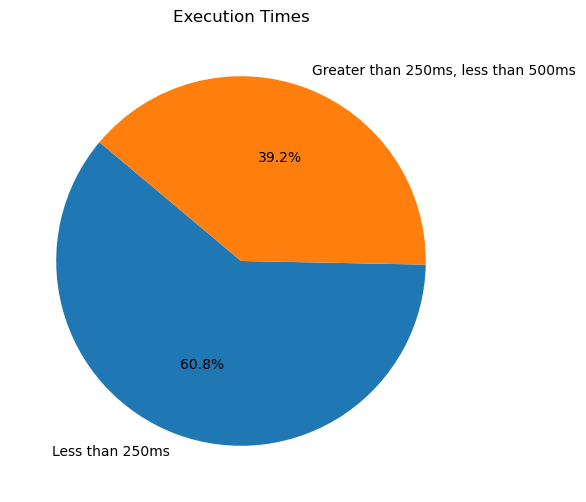

In [93]:
import matplotlib.pyplot as plt
import pandas as pd

def categorize_time(time):
    if time < 10:
        return 'Error'
    elif time < 250:
        return 'Less than 250ms'
    elif time < 500:
        return 'Greater than 250ms, less than 500ms'
    else:
        return 'Greater than 500ms'

df = pd.DataFrame({'predicted_time': predict_vals})
df['time_category'] = df['predicted_time'].apply(categorize_time)

time_category_counts = df['time_category'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(time_category_counts, labels=time_category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Execution Times')
plt.show()


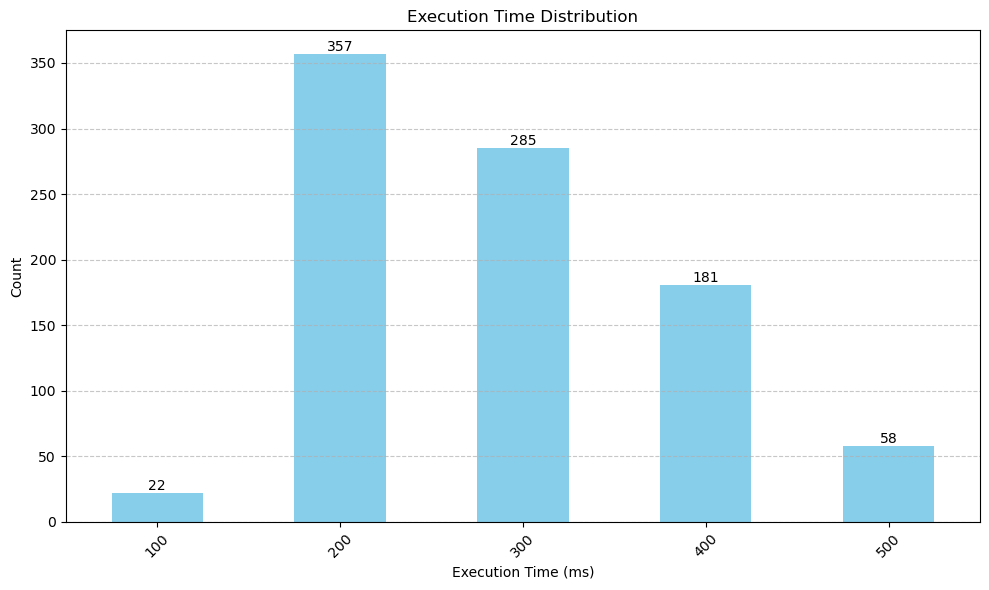

In [96]:
def categorize_time(time):
    return int(time / 100) * 100 + 100

df['time_category'] = df['predicted_time'].apply(categorize_time)

time_category_counts = df['time_category'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
ax = time_category_counts.plot(kind='bar', color='skyblue')
plt.title('Execution Time Distribution')
plt.xlabel('Execution Time (ms)')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

### **Code2Vec**
In this section, the Code2Vec model will be setup. We need to change the dataset that is currently being used to be able to use the Code2Vec model as it was designed for Java. 